# Green Manufacturing
Based on UNIDO methodology: https://downloads.unido.org/ot/25/13/25133359/WP_1_2022.pdf

In [2]:
import sys
import os

sys.path.append('/Users/janinedevera/Documents/ADB/Climate/eemrio/src')
os.chdir('/Users/janinedevera/Documents/ADB/Climate/eemrio/')

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import duckdb
from mriomain import mrio

## I. Data

In [4]:
input_mrio = './data/mrio.parquet'
input_ee = './data/ee.parquet'
countries_mapping = pd.read_excel('./data/raw/countries.xlsx').drop_duplicates(subset=['iso_a3'], keep='last')
sectors_mapping = pd.read_csv('./data/raw/sectors.csv')

years = [2017, 2018, 2019, 2020, 2021, 2022]

In [5]:
# column labels
df = duckdb.sql(f"SELECT * FROM '{input_ee}'").df()
labels = df.columns[4:2559].to_frame(index=False)[0].str.split("_", expand=True)
labels = labels.set_axis(['country', 'mrio_sector'], axis=1)

# mapping: ghg sectors
ghg_sectors = sorted(df['sector'].unique().tolist())

# mapping: mrio sectors
sectors_map = sectors_mapping.iloc[:, 0:3]
sectors_map['mrio_sector'] = 'c' + sectors_map['c_ind'].astype(str)
sectors_map = sectors_map.rename(columns={'c_ind': 'sector_no', 'c_name': 'sector_name', 'c_name_short': 'sector_name_short'})
agg_map = sectors_mapping.iloc[:, [0, 5]]

# mapping: regions
region_map = countries_mapping.iloc[:, [8,12]]

# industrial sectors 
ind_sectors = [f"c{i}" for i in range(3, 16+1)]

In [6]:
# mrio value added data
gva = pd.DataFrame()
for year in years: 
    temp = mrio.MRIO(f'{input_mrio}', year)
    gva[year] = temp.va.data

gva = pd.concat([labels, gva], axis=1)
gva = pd.melt(gva, id_vars=['country', 'mrio_sector'], value_vars=[2017, 2018, 2019, 2020, 2021, 2022]).rename(columns={"value": "total_gva", "variable": "year"})

In [7]:
# baci data
baci_years = [filename for filename in os.listdir('./data/raw/baci/') if filename.startswith("BACI_")]

country_codes = pd.read_csv('./data/raw/baci/country_codes_V202401b.csv')
product_codes = pd.read_csv('./data/raw/baci/product_codes_HS17_V202401b.csv')

# adb mapping
mrio_mapping = pd.read_excel('./data/raw/product-correspondence.xlsx').drop_duplicates(subset=['HS17'], keep='first')
countries_mapping = pd.read_excel('./data/raw/countries.xlsx')

# industrial sectors 
ind_sectors = [f"c{i}" for i in range(3, 16+1)]

In [8]:
# combine data for all years
temp_list = []

for filename in baci_years:
    filepath = os.path.join('./data/raw/baci/', filename)
    df = pd.read_csv(filepath)  
    temp_list.append(df) 

baci_raw = pd.concat(temp_list, ignore_index=True).drop(columns=['q'])
baci_raw.columns = ['year', 'exporter', 'importer', 'product', 'value']
baci_raw['value'] = pd.to_numeric(baci_raw['value'])

In [9]:
baci_raw.dtypes

year          int64
exporter      int64
importer      int64
product       int64
value       float64
dtype: object

In [10]:
baci_raw

,year,exporter,importer,product,value
0,2021,4,20,420229,0.592
1,2021,4,20,621050,0.200
2,2021,4,20,640319,0.167
3,2021,4,20,870899,0.456
4,2021,4,24,382499,52.827
...,...,...,...,...,...
65646553,2019,894,854,722830,23.952
65646554,2019,894,854,722880,21.926
65646555,2019,894,854,820719,16.927
65646556,2019,894,858,240120,312.046


In [11]:
baci_raw[(baci_raw['year'] == 2022) & (baci_raw['exporter'] == 276)]['value'].sum()

1599460451.002

In [12]:
# aggregate importers 
baci_agg = (
    baci_raw
    .groupby(['year', 'exporter', 'product'])
    .agg('sum').reset_index()
    .drop(columns=['importer'])
    .rename(columns={"value": "export_val"})
)

# map to country and product names
baci = pd.merge(baci_agg, country_codes, left_on='exporter', right_on='country_code').drop(columns=['country_code'])
baci = pd.merge(baci, product_codes, left_on='product', right_on='code').drop(columns=['code'])

# extract mrio countries
countries_mapping = countries_mapping[['iso_a3', 'code', 'name_adb', 'region_wb', 'mrio', 'region']]

baci_mrio = (pd.merge(baci, countries_mapping, left_on='country_iso3', right_on='iso_a3'))
baci_mrio = baci_mrio[baci_mrio['mrio'].notna()].reset_index()

# load UNIDO green products list 
green_list = pd.read_excel('./data/raw/UNIDO-green-product-list-2022.xlsx')
green_list = green_list['HS CODE'].to_list()

# identify green products
baci_mrio['green'] = baci_mrio['product'].isin(green_list).astype(int)

In [13]:
baci_mrio['green'].value_counts()

green
0    1752134
1      94840
Name: count, dtype: int64

In [14]:
# main baci datasets 
baci_mrio = (pd.merge(baci_mrio, mrio_mapping, left_on='product', right_on='HS17')).drop(columns=['HS2002'])
baci_mfg = baci_mrio[baci_mrio['MRIOsec'].isin(ind_sectors)].reset_index().drop(columns=['level_0', 'index'])

In [15]:
baci_mrio

,index,year,exporter,product,export_val,country_name,country_iso2,country_iso3,description,iso_a3,...,green,CPCcode,HS02,HS07,HS12,HS17,HS22,ISIC,MRIOsec,MRIOdesc
0,11005,2017,32,10121,10275.187,Argentina,AR,ARG,"Horses: live, pure-bred breeding animals",ARG,...,0,2113,10110,10110,10121,10121,10121,121,c1,"Agriculture, Hunting, Forestry and Fishing"
1,11006,2017,32,10129,17437.784,Argentina,AR,ARG,"Horses: live, other than pure-bred breeding an...",ARG,...,0,2113,10190,10190,10129,10129,10129,121,c1,"Agriculture, Hunting, Forestry and Fishing"
2,11007,2017,32,10221,748.194,Argentina,AR,ARG,"Cattle: live, pure-bred breeding animals",ARG,...,0,2111,10210,10210,10221,10221,10221,121,c1,"Agriculture, Hunting, Forestry and Fishing"
3,11008,2017,32,10229,35.133,Argentina,AR,ARG,"Cattle: live, other than pure-bred breeding an...",ARG,...,0,2111,10290,10290,10229,10229,10229,121,c1,"Agriculture, Hunting, Forestry and Fishing"
4,11009,2017,32,10392,133.220,Argentina,AR,ARG,"Swine: live, other than pure-bred breeding ani...",ARG,...,0,2121,10392,10392,10392,10392,10392,122,c1,"Agriculture, Hunting, Forestry and Fishing"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1636766,3332145,2022,842,970200,171132.133,USA,US,USA,"Engravings, prints and lithographs: original",USA,...,0,38960,970200,970200,970200,970200,970290,9214,c34,"Other Community, Social and Personal Services"
1636767,3332146,2022,842,970300,1070985.861,USA,US,USA,"Sculptures and statuary: original, in any mate...",USA,...,0,38960,970300,970300,970300,970300,970310,9214,c34,"Other Community, Social and Personal Services"
1636768,3332147,2022,842,970400,9525.265,USA,US,USA,"Stamps, postage or revenue: stamp-postmarks, f...",USA,...,0,38960,970400,970400,970400,970400,970400,9214,c34,"Other Community, Social and Personal Services"
1636769,3332148,2022,842,970500,366765.122,USA,US,USA,Collections and collectors' pieces: of zoologi...,USA,...,0,38960,970500,970500,970500,970500,970510,9214,c34,"Other Community, Social and Personal Services"


In [16]:
# exports: green shares per sector
sector_df = (
    baci_mfg[['year', 'country_iso3', 'code', 'name_adb', 'region', 'MRIOsec', 'MRIOdesc', 'green', 'export_val']]
    .groupby(['year', 'country_iso3', 'code', 'name_adb', 'region', 'MRIOsec', 'MRIOdesc', 'green'])
    .agg('sum')
    .reset_index()
)

sector_df['total_exports'] = sector_df.groupby(['year', 'country_iso3', 'code', 'name_adb', 'region', 'MRIOsec', 'MRIOdesc'])['export_val'].transform('sum')
sector_df['export_share'] = sector_df['export_val'] / sector_df['total_exports']

In [17]:
sector_df

,year,country_iso3,code,name_adb,region,MRIOsec,MRIOdesc,green,export_val,total_exports,export_share
0,2017,ARE,UAE,United Arab Emirates,Middle East and North Africa,c10,Rubber and Plastics,0,8.567984e+05,8.688346e+05,0.986147
1,2017,ARE,UAE,United Arab Emirates,Middle East and North Africa,c10,Rubber and Plastics,1,1.203619e+04,8.688346e+05,0.013853
2,2017,ARE,UAE,United Arab Emirates,Middle East and North Africa,c11,Other Non-Metallic Mineral,0,1.195304e+06,1.264833e+06,0.945029
3,2017,ARE,UAE,United Arab Emirates,Middle East and North Africa,c11,Other Non-Metallic Mineral,1,6.952851e+04,1.264833e+06,0.054971
4,2017,ARE,UAE,United Arab Emirates,Middle East and North Africa,c12,Basic Metals and Fabricated Metal,0,3.179533e+07,3.216571e+07,0.988485
...,...,...,...,...,...,...,...,...,...,...,...
10976,2022,VNM,VIE,Viet Nam,East Asia and Pacific,c7,"Pulp, Paper, Paper , Printing and Publishing",0,2.052957e+06,2.315690e+06,0.886542
10977,2022,VNM,VIE,Viet Nam,East Asia and Pacific,c7,"Pulp, Paper, Paper , Printing and Publishing",1,2.627330e+05,2.315690e+06,0.113458
10978,2022,VNM,VIE,Viet Nam,East Asia and Pacific,c8,"Coke, Refined Petroleum and Nuclear Fuel",0,2.546604e+05,2.546604e+05,1.000000
10979,2022,VNM,VIE,Viet Nam,East Asia and Pacific,c9,Chemicals and Chemical Products,0,1.132008e+07,1.174395e+07,0.963907


In [18]:
# domestic: green shares per sector
sector_dom = (pd.merge(sector_df, gva, left_on=['code', 'year', 'MRIOsec'], right_on=['country', 'year', 'mrio_sector'])).drop(columns=['code', 'MRIOsec'])
sector_dom['va_val'] = sector_dom['export_share'] * sector_dom['total_gva']

In [19]:
sector_dom

,year,country_iso3,name_adb,region,MRIOdesc,green,export_val,total_exports,export_share,country,mrio_sector,total_gva,va_val
0,2017,ARE,United Arab Emirates,Middle East and North Africa,Rubber and Plastics,0,8.567984e+05,8.688346e+05,0.986147,UAE,c10,1073.232715,1058.364949
1,2017,ARE,United Arab Emirates,Middle East and North Africa,Rubber and Plastics,1,1.203619e+04,8.688346e+05,0.013853,UAE,c10,1073.232715,14.867766
2,2017,ARE,United Arab Emirates,Middle East and North Africa,Other Non-Metallic Mineral,0,1.195304e+06,1.264833e+06,0.945029,UAE,c11,3589.678268,3392.351815
3,2017,ARE,United Arab Emirates,Middle East and North Africa,Other Non-Metallic Mineral,1,6.952851e+04,1.264833e+06,0.054971,UAE,c11,3589.678268,197.326453
4,2017,ARE,United Arab Emirates,Middle East and North Africa,Basic Metals and Fabricated Metal,0,3.179533e+07,3.216571e+07,0.988485,UAE,c12,7691.511218,7602.946540
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10976,2022,VNM,Viet Nam,East Asia and Pacific,"Pulp, Paper, Paper , Printing and Publishing",0,2.052957e+06,2.315690e+06,0.886542,VIE,c7,2667.545990,2364.892132
10977,2022,VNM,Viet Nam,East Asia and Pacific,"Pulp, Paper, Paper , Printing and Publishing",1,2.627330e+05,2.315690e+06,0.113458,VIE,c7,2667.545990,302.653858
10978,2022,VNM,Viet Nam,East Asia and Pacific,"Coke, Refined Petroleum and Nuclear Fuel",0,2.546604e+05,2.546604e+05,1.000000,VIE,c8,4900.252255,4900.252255
10979,2022,VNM,Viet Nam,East Asia and Pacific,Chemicals and Chemical Products,0,1.132008e+07,1.174395e+07,0.963907,VIE,c9,6082.549841,5863.014777


In [20]:
# green shares per country
country_df = (
    sector_dom[sector_dom['green'] == 1]
.groupby(['year', 'country', 'name_adb', 'region'])
.agg(
    {
        'export_val': 'sum',
        'total_exports': 'sum',
        'total_gva': 'sum',
        'va_val': 'sum', 
    }
)
.reset_index()
)

country_df['va_share'] = country_df['va_val'] / country_df['total_gva']
country_df['export_share'] = country_df['export_val'] / country_df['total_exports']

In [21]:
country_df[country_df['country'] == 'KOR']

,year,country,name_adb,region,export_val,total_exports,total_gva,va_val,va_share,export_share
35,2017,KOR,Republic of Korea,East Asia and Pacific,4.440353e+07,4.661920e+08,449849.156069,44570.025825,0.099078,0.095247
106,2018,KOR,Republic of Korea,East Asia and Pacific,4.314262e+07,4.833784e+08,508912.915240,46058.589727,0.090504,0.089252
177,2019,KOR,Republic of Korea,East Asia and Pacific,3.756133e+07,4.279927e+08,463719.545146,40708.196366,0.087786,0.087762
248,2020,KOR,Republic of Korea,East Asia and Pacific,3.643975e+07,4.154038e+08,463171.902362,40777.093413,0.088039,0.087721
319,2021,KOR,Republic of Korea,East Asia and Pacific,3.587677e+07,5.110857e+08,518893.137044,36895.543793,0.071104,0.070197
390,2022,KOR,Republic of Korea,East Asia and Pacific,3.179069e+07,5.169826e+08,525761.945524,33794.002181,0.064276,0.061493


## II. Plots

In [22]:
# chart settings
plt.rcParams['font.family'] = 'Arial'

region_colors = {
    'East Asia and Pacific': '#007db7',
    'Europe and Central Asia': '#8dc63f', 
    'Latin America and the Caribbean': '#e9532b',
    'Middle East and North Africa': '#f2e600',
    'North America': '#f57f29',
    'South Asia': '#6dcff6',
}

### A. Leading exporters of green products (USD)

In [23]:
# 2022
gm_2022 = country_df[(country_df['year'] == 2022)].copy()
gm_2022['export_mil'] = gm_2022['export_val'] / 10000000
gm_2022['va_mil'] = gm_2022['va_val'] / 10000

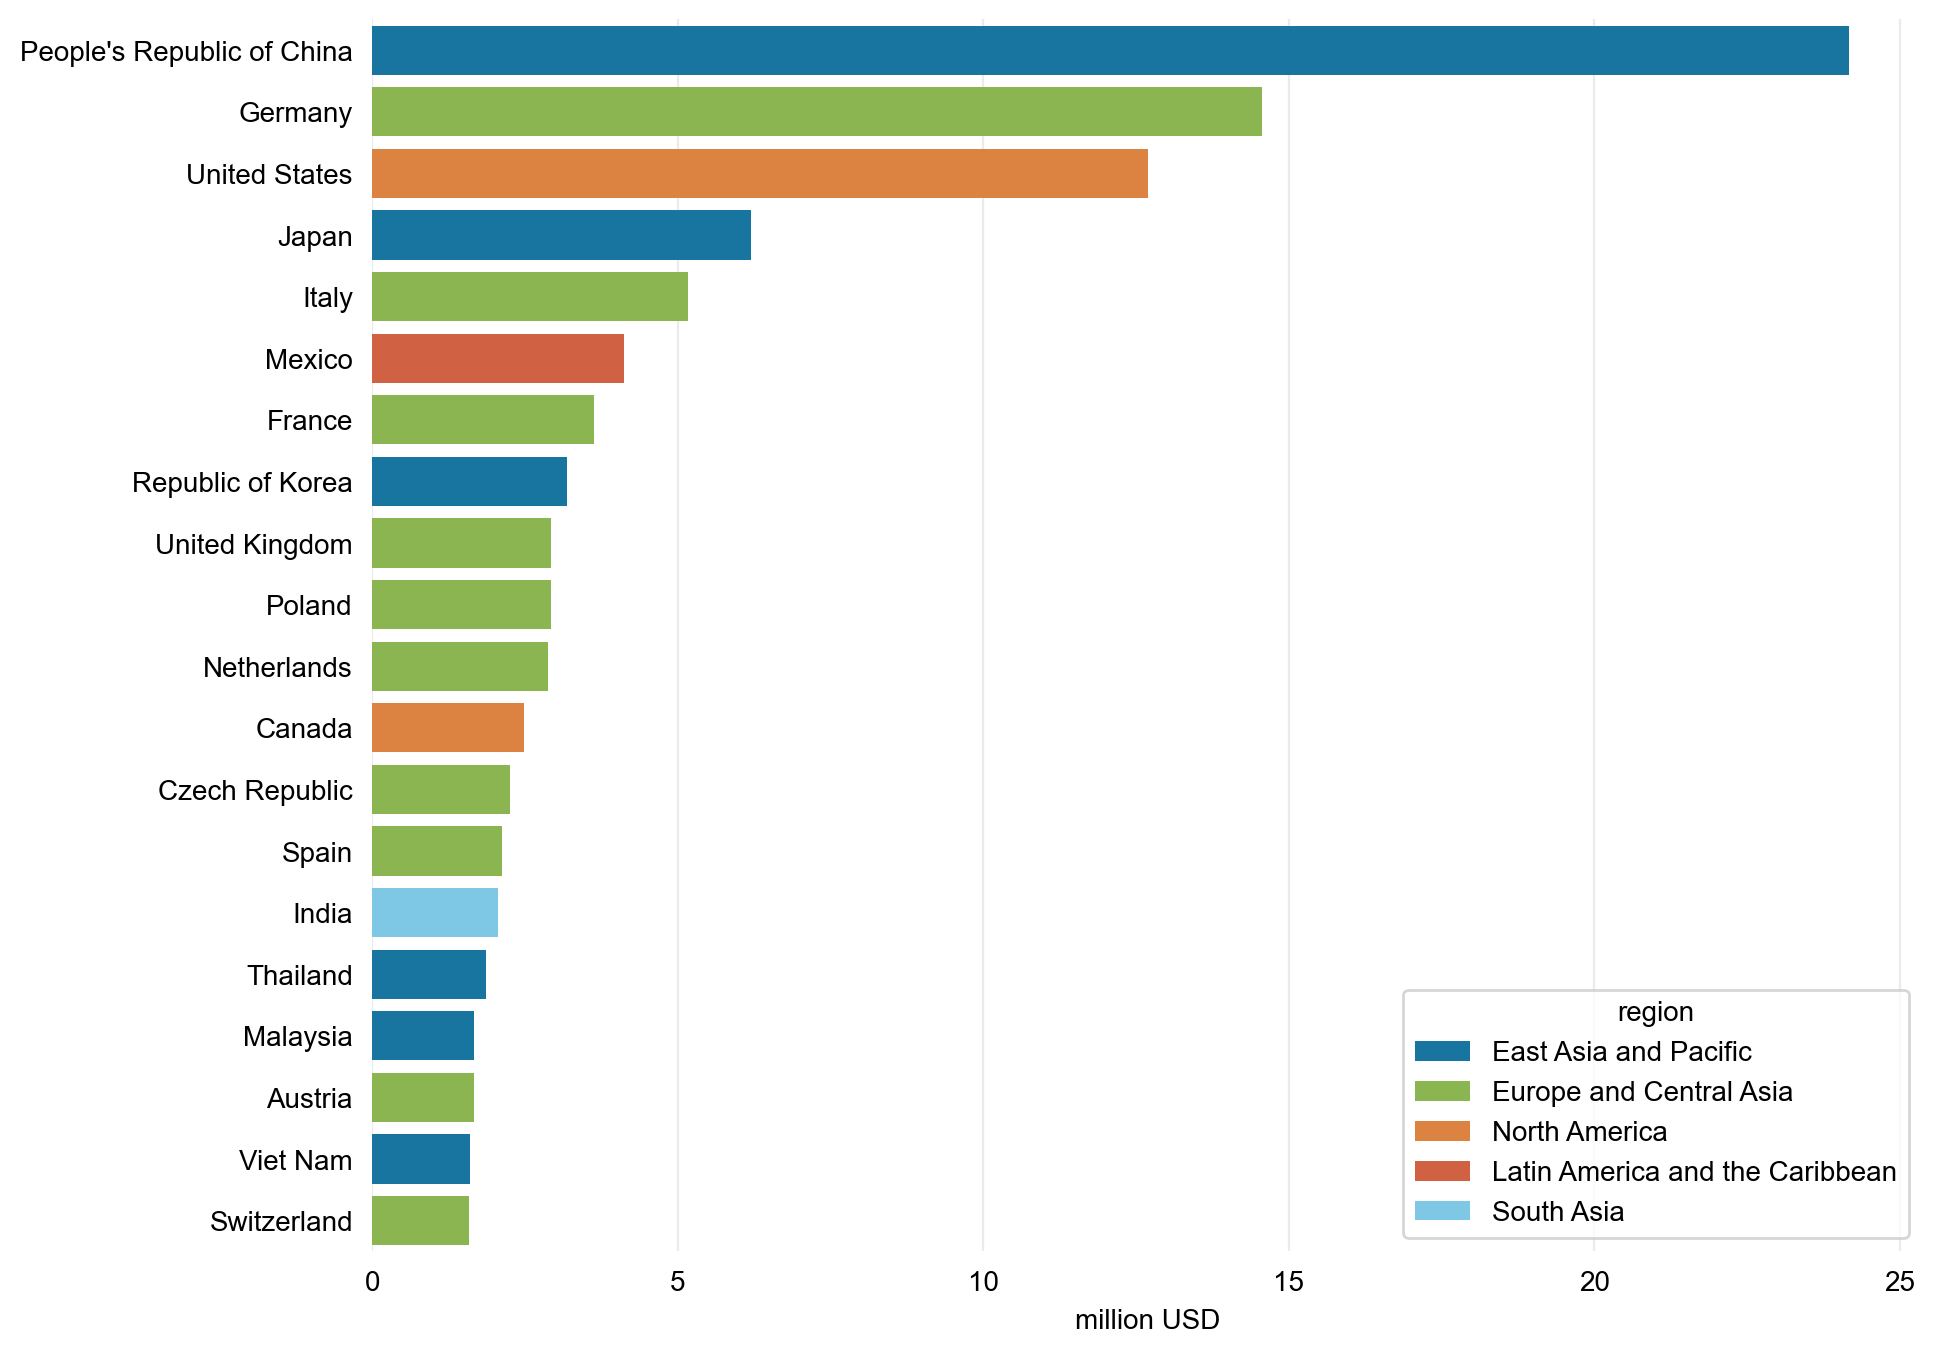

In [367]:
gm_top = gm_2022.sort_values(by='export_val', ascending=False)[:20].copy()

f, ax = plt.subplots(figsize=(10, 8), dpi=200)
sns.barplot(x="export_mil", y="name_adb", data=gm_top, errorbar=None, zorder=2, 
            hue="region", palette=region_colors)

plt.grid(axis='x', color='#EBEBEB') 
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tick_params(left=False, bottom=False) 
plt.xlabel('million USD', fontsize=10)
plt.ylabel('')
#plt.title('Top 20 exporters of green products, 2022', y=1.01, fontsize=10, fontweight='bold')
sns.despine(left=True, bottom=True)
plt.savefig('./charts/green-plot-01.png', bbox_inches='tight')
plt.show()

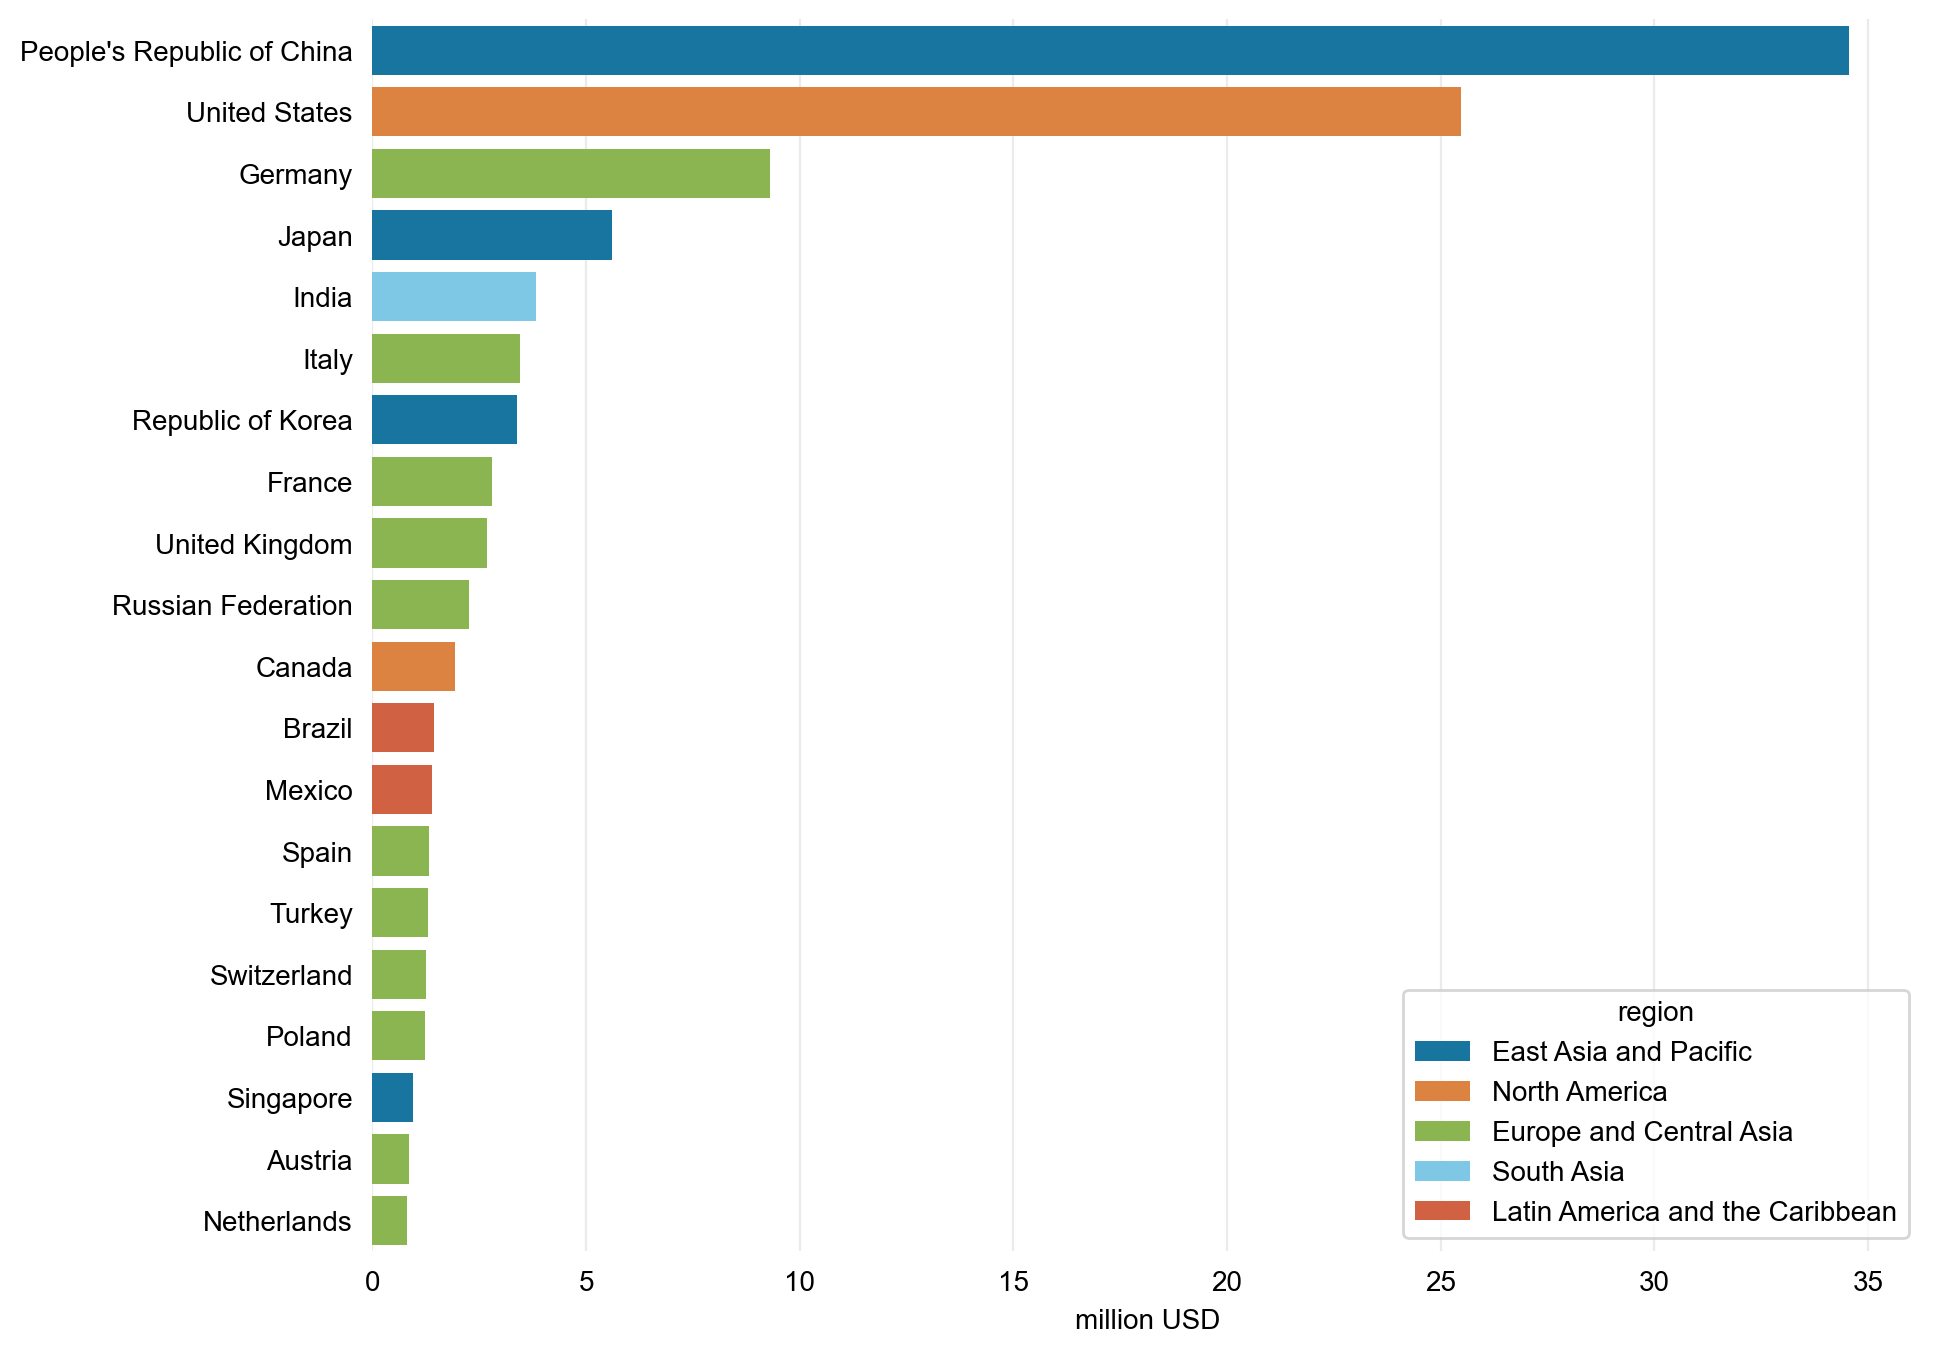

In [387]:
gm_top = gm_2022.sort_values(by='va_val', ascending=False)[:20].copy()

f, ax = plt.subplots(figsize=(10, 8), dpi=200)
sns.barplot(x="va_mil", y="name_adb", data=gm_top, errorbar=None, zorder=2, 
            hue="region", palette=region_colors)

plt.grid(axis='x', color='#EBEBEB') 
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tick_params(left=False, bottom=False) 
plt.xlabel('million USD', fontsize=10)
plt.ylabel('')
#plt.title('Top 20 exporters of green products, 2022', y=1.01, fontsize=10, fontweight='bold')
sns.despine(left=True, bottom=True)
plt.savefig('./charts/green-plot-02.png', bbox_inches='tight')
plt.show()

### B. Share of green manufactures to value added

In [24]:
gm_ap = country_df[country_df['country'].isin(['KOR', 'JPN', 'PRC', 'THA', 'MAL', 'VIE', 'IND', 'SIN'])]
gm_ap_wide = gm_ap.pivot(index=['country', 'name_adb', 'region'], columns='year', values='va_share').reset_index()

In [30]:
gm_ap

,year,country,name_adb,region,export_val,total_exports,total_gva,va_val,va_share,export_share
28,2017,IND,India,South Asia,1.145954e+07,2.135684e+08,3.787443e+05,24434.753091,0.064515,0.053657
32,2017,JPN,Japan,East Asia and Pacific,6.362950e+07,6.143685e+08,8.578686e+05,67048.535472,0.078157,0.103569
35,2017,KOR,Republic of Korea,East Asia and Pacific,4.440353e+07,4.661920e+08,4.498492e+05,44570.025825,0.099078,0.095247
41,2017,MAL,Malaysia,East Asia and Pacific,1.312581e+07,1.884198e+08,6.072259e+04,4698.653626,0.077379,0.069663
54,2017,PRC,People's Republic of China,East Asia and Pacific,1.617567e+08,1.871631e+09,3.139785e+06,236541.512808,0.075337,0.086426
58,2017,SIN,Singapore,East Asia and Pacific,8.796843e+06,1.501016e+08,6.395390e+04,4984.237376,0.077935,0.058606
65,2017,THA,Thailand,East Asia and Pacific,1.652191e+07,2.099269e+08,1.055402e+05,6488.133131,0.061475,0.078703
70,2017,VIE,Viet Nam,East Asia and Pacific,8.323221e+06,1.409981e+08,5.912259e+04,2816.388080,0.047636,0.059031
99,2018,IND,India,South Asia,1.346847e+07,2.281121e+08,4.507003e+05,31502.544791,0.069897,0.059043
103,2018,JPN,Japan,East Asia and Pacific,6.653704e+07,6.519903e+08,8.995203e+05,71870.290759,0.079898,0.102052


In [66]:
gm_asia = country_df[country_df['region'].isin(['East Asia and Pacific', 'South Asia'])]
gm_agg = country_df[['year', 'export_val', 'total_exports', 'total_gva', 'va_val']].groupby(['year']).aggregate('sum').reset_index()
gm_agg['export_share'] = gm_agg['export_val'] / gm_agg['total_exports']

In [57]:
country_df['region'].unique()

array(['Latin America and the Caribbean', 'Europe and Central Asia',
       'East Asia and Pacific', 'South Asia', 'North America',
       'Middle East and North Africa'], dtype=object)

In [67]:
gm_agg

,year,export_val,total_exports,total_gva,va_val,export_share
0,2017,9.644247e+08,1.087487e+10,1.187208e+07,9.697336e+05,0.088684
1,2018,1.039903e+09,1.182675e+10,1.283924e+07,1.039412e+06,0.087928
2,2019,1.022865e+09,1.156866e+10,1.276808e+07,1.032086e+06,0.088417
3,2020,9.775185e+08,1.096879e+10,1.213859e+07,1.019282e+06,0.089118
4,2021,1.155615e+09,1.325640e+10,1.432135e+07,1.166206e+06,0.087174
5,2022,1.190222e+09,1.397431e+10,1.463767e+07,1.187811e+06,0.085172


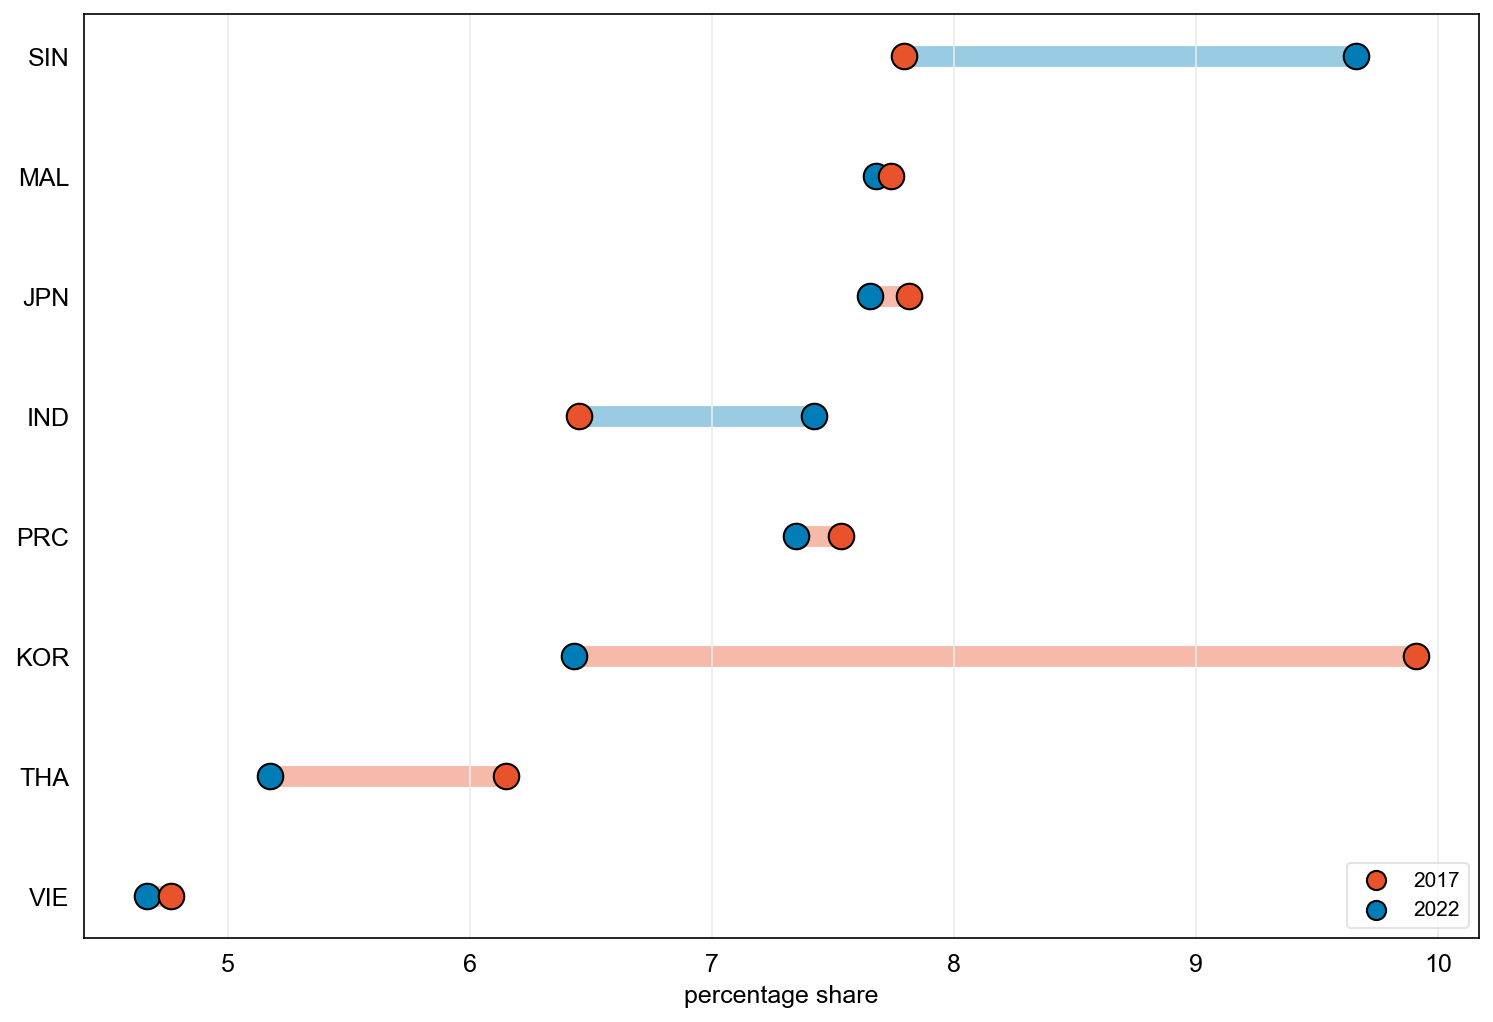

In [25]:
ordered_df = gm_ap_wide.sort_values(by=2022)

plt.figure(figsize=(12, 8), dpi=150, edgecolor='#EBEBEB')

plt.scatter(x=ordered_df[2017]*100, y=ordered_df['country'], color='#e9532b', alpha=1, label='2017', s=150, zorder=4, edgecolor='black')
#plt.scatter(x=ordered_df[2019]*100, y=ordered_df['country'], color='#8dc63f', alpha=1, label='2019', s=120, zorder=3)
plt.scatter(x=ordered_df[2022]*100, y=ordered_df['country'], color='#007db7', alpha=1, label='2022', s=150, zorder=2, edgecolor='black')

min_val = ordered_df[[2017, 2022]].min(axis=1)
max_val = ordered_df[[2017, 2022]].max(axis=1)
#plt.hlines(y=ordered_df['country'], xmin=min_val*100, xmax=max_val*100, color='#6dcff6', alpha=0.4, lw=10, zorder=1)

for idx, row in ordered_df.iterrows():
    color = '#e9532b' if row[2017] > row[2022] else '#007db7'  # Determine color based on the condition
    plt.hlines(y=row['country'], xmin=min_val[idx]*100, xmax=max_val[idx]*100, color=color, alpha=0.4, lw=10, zorder=1)

plt.grid(axis='x', color='#EBEBEB') 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tick_params(left=False, bottom=False) 
plt.xlabel('percentage share', fontsize=12, y=-1.01)
plt.ylabel('')
#plt.xlim((0,0.2))
#plt.title('Total Emission Impact Ratio of Industrial Sectors (2017, 2019, 2021)', y=1.01, fontsize=10, fontweight='bold')
legend = plt.legend(fontsize=10, markerscale=0.75, loc='lower right')
legend.get_frame().set_edgecolor('#DDDDDD')
plt.savefig('./charts/green-plot-04.png', bbox_inches='tight')
plt.show()

### C. Change in share of green manufactures to value added (2017 and 2022)

In [26]:
country_wide = country_df.pivot(index=['country', 'name_adb', 'region'], columns='year', values='va_share').reset_index()

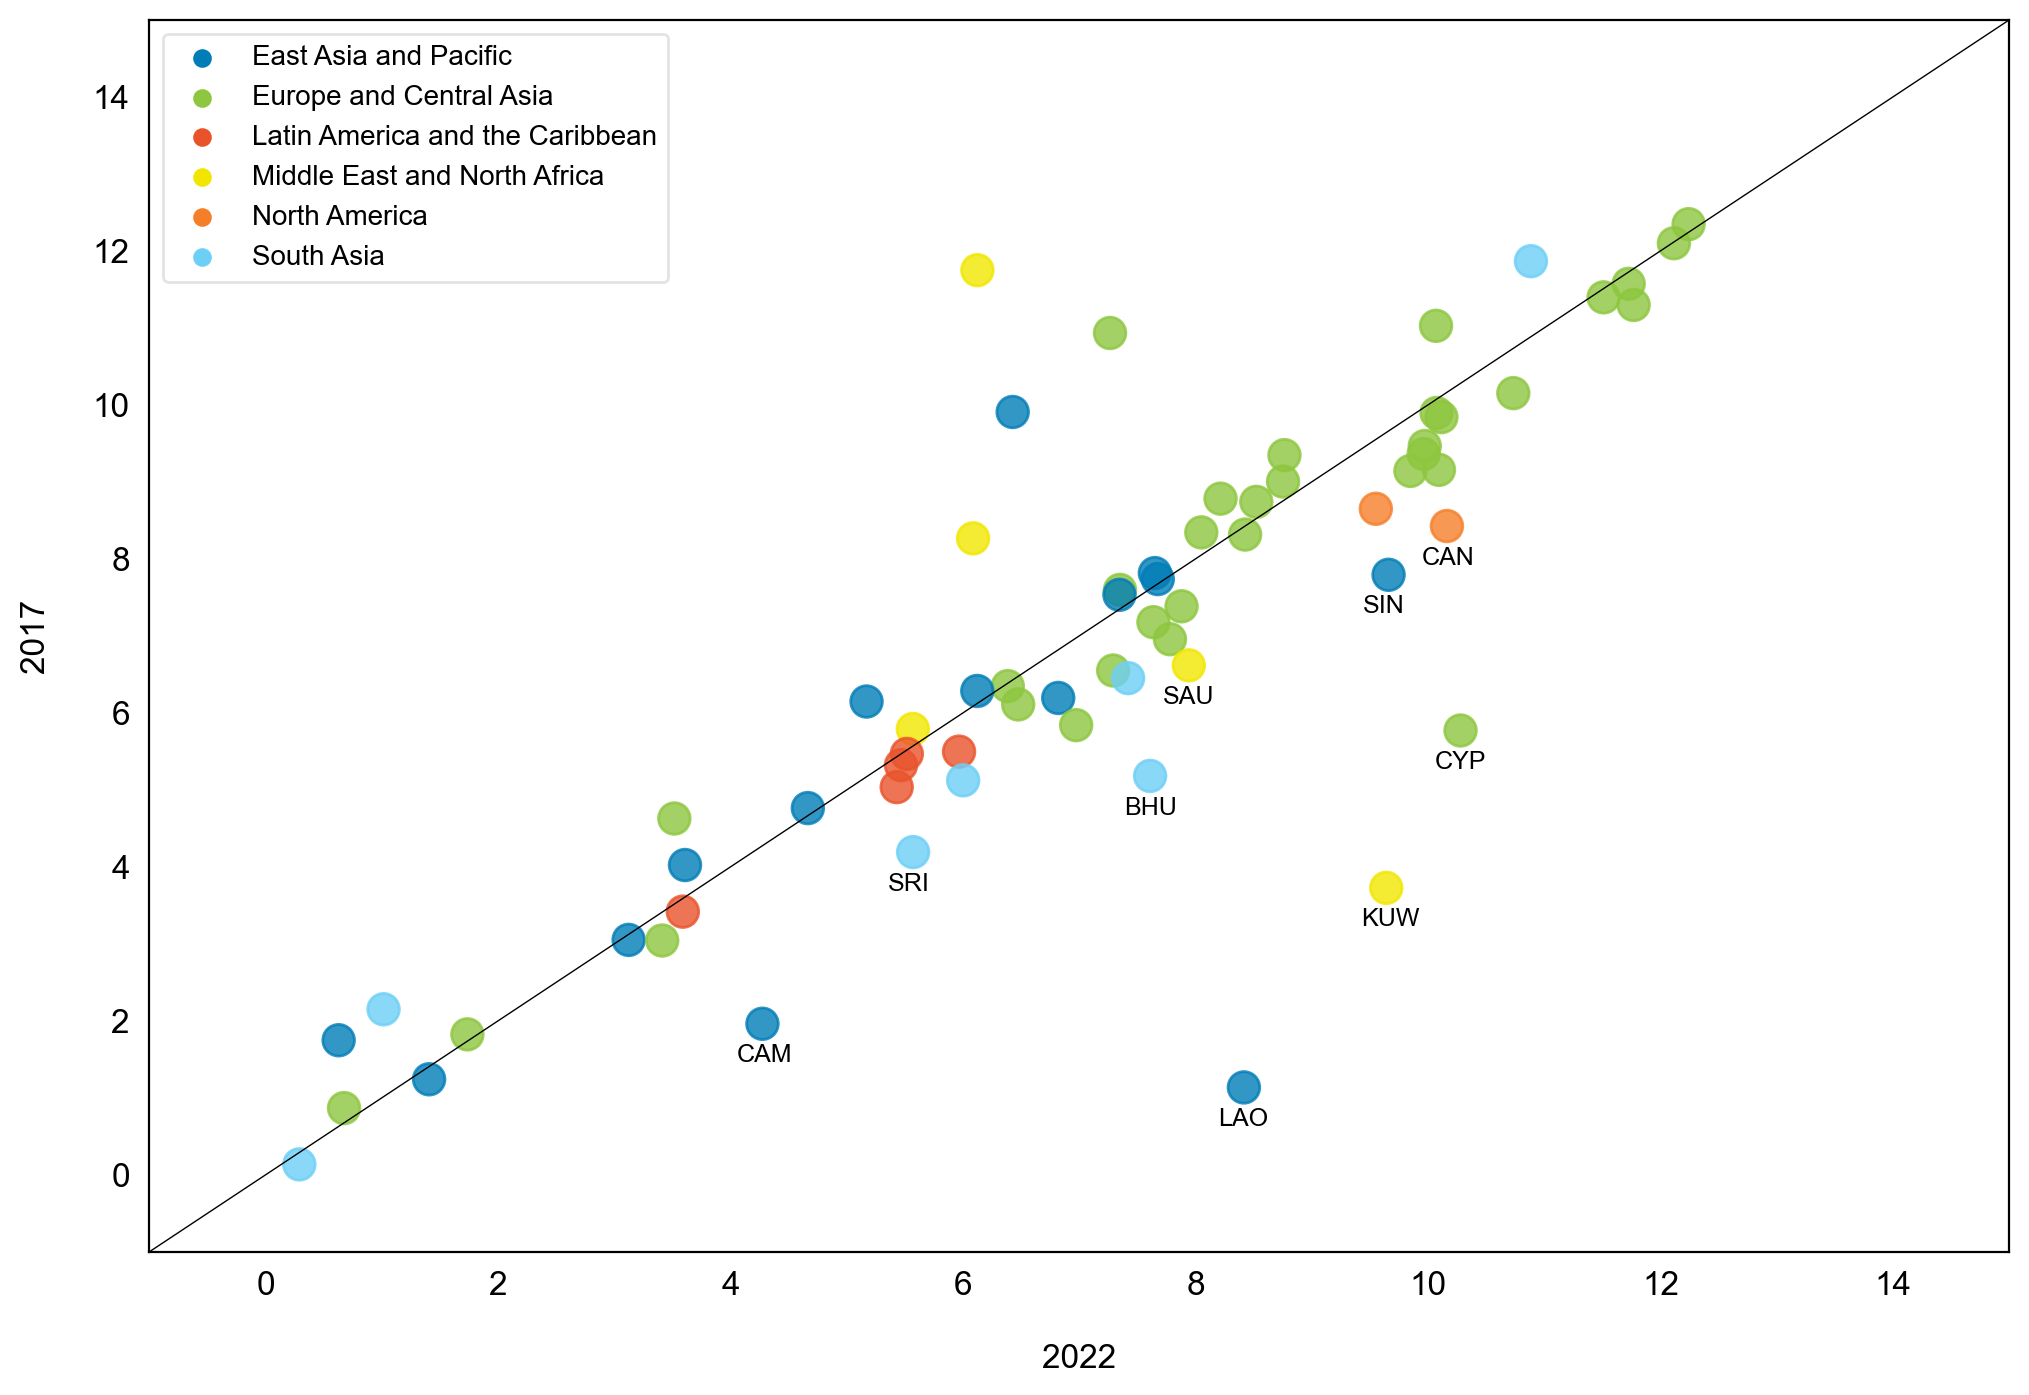

In [370]:
country_wide['color'] = country_wide['region'].map(region_colors)

plt.figure(figsize=(12, 8), dpi=200, edgecolor='#EBEBEB')
for region, color in region_colors.items():
    plt.scatter([], [], color=color, label=region)

plt.scatter(x=country_wide[2022]*100, 
            y=country_wide[2017]*100,
            s=130, 
            alpha=0.8, 
            zorder=2,
            c=country_wide['color']) 

for i, (x, y) in enumerate(zip(country_wide[2022]*100, country_wide[2017]*100)):
    #if y < ghg_world*100 and x > va_world*100+10:
    if y < x-1.3: 
        plt.annotate(country_wide.country.iloc[i], (x-0.22, y-0.5), fontsize=9)

plt.plot([-1, 15], [-1, 15], color='#000000', linewidth=0.5)
plt.xlim((-1,15))
plt.ylim((-1,15))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tick_params(left=False, bottom=False) 
plt.xlabel('2022', fontsize=12, labelpad=15)
plt.ylabel('2017', fontsize=12, labelpad=15)
#plt.title('Manufacturing share in greenhouse gas emissions and value added (by country), 2022', y=1.02, fontsize=13, fontweight='bold')
legend = plt.legend(fontsize=10, markerscale=0.95, loc='upper left')
legend.get_frame().set_edgecolor('#DDDDDD')
plt.savefig('./charts/overview-plot-03.png')
plt.show()